# **Predictive Modeling for Loan Recovery Optimization in Financial Institutions**

## **Abstract**

Loan default remains a critical challenge for financial institutions, leading to high non-performing loans (NPLs) and financial instability. Traditional recovery strategies often rely on reactive approaches, resulting in inefficiencies and resource wastage. This research proposes a predictive analytics model to optimize loan recovery by identifying high-risk borrowers and enabling targeted collection efforts. By leveraging machine learning techniques, the study aims to enhance recovery rates while minimizing operational costs. The model’s effectiveness will be assessed using AUC-ROC as the primary metric, complemented by Precision at K, Recovery Rate, and Operational Cost Reduction.

## **Introduction**

Loan delinquency significantly affects the financial health of lending institutions, leading to liquidity constraints and revenue losses. Conventional recovery strategies often follow generalized approaches that do not account for borrower-specific risk levels. Predictive analytics offers a data-driven solution by enabling institutions to assess risk early and optimize collection efforts. This study explores the application of machine learning techniques to develop a loan recovery model that enhances financial sustainability.

## **Problem Statement**

Loan defaults contribute to financial losses and increased recovery costs for lenders. Current collection strategies are largely manual and inefficient, leading to suboptimal results. The lack of predictive capabilities limits institutions from prioritizing high-risk borrowers for targeted recovery efforts. This study aims to develop a machine learning model that classifies borrowers based on their likelihood of repaying overdue loans, improving the efficiency and effectiveness of recovery strategies.

## **Objectives**

The key objectives of this study are:

1. To analyze historical loan repayment data and identify key risk factors influencing default.

2. To develop a predictive model for classifying borrowers based on their likelihood of repayment.

3. To evaluate model performance using relevant success metrics, ensuring both technical accuracy and business applicability.

4. To assess the impact of the model on loan recovery rates and operational efficiency.

5. To propose a data-driven strategy for optimizing loan collection efforts.


## **Metric of Success**

The primary objective of this study is to develop a machine learning model capable of classifying loan recovery outcomes into three categories: Fully Recovered, Partially Recovered, and Written Off. The model's success is evaluated based on key performance metrics, including Logarithmic Loss (Log Loss), Recall, F1-Score, and Accuracy. These metrics were selected to balance overall model performance while ensuring the model correctly identifies high-risk cases (i.e., loans that are only partially recovered or completely written off).

The model is considered successful if:

- Log Loss ≤ 0.70 is achieved, indicating that the model makes well-calibrated probabilistic predictions.

- Log Loss ≤ 0.50 is considered excellent, demonstrating highly confident and reliable predictions.

- Recall for Partially Recovered (Class 1) ≥ 70%, ensuring that at least 70% of partially recovered loans are correctly classified.

- Recall for Written Off (Class 2) ≥ 60%, ensuring that a majority of high-risk cases are correctly flagged.

To balance precision and recall, the weighted F1-score is also used. The model must achieve:

- Weighted F1-score ≥ 0.75 to maintain an overall strong classification performance.

## **Dataset**

This dataset contains information about borrowers, loans, and their repayment status.

1. **Borrower Information**

These columns describe the borrower’s profile:

- Borrower_ID – A unique identifier for each borrower (Not useful for analysis).

- Age – The borrower's age. Helps determine if younger or older individuals default more.

- Gender – Male or Female. May indicate trends in repayment behavior.

- Employment_Type – Categorizes borrowers as Salaried or Self-Employed.

- Monthly_Income – How much a borrower earns per month. Critical for assessing their ability to repay.

- Num_Dependents – Number of people financially dependent on the borrower.

2. **Loan Details**

These columns describe the loan given to the borrower:

- Loan_ID – A unique identifier for each loan (Not useful for analysis).

- Loan_Amount – The total amount borrowed.

- Loan_Tenure – Loan duration in months (e.g., 12 months, 24 months, etc.).

- Interest_Rate – The rate charged on the loan (% per year).

- Loan_Type – Could be Personal Loan, Mortgage, Auto Loan, Education Loan, etc.

- Collateral_Value – If the loan is secured, this is the value of the asset used as collateral.

- Outstanding_Loan_Amount – The amount still unpaid by the borrower.

- Monthly_EMI – The fixed Equated Monthly Installment (EMI) the borrower must pay.

3. **Repayment & Loan Recovery Information**

These columns track how well borrowers are repaying their loans:

- Payment_History – Shows past repayment behavior:

"On-Time" → Paid without delays.

"Delayed" → Paid late but eventually cleared.

"Defaulted" → Failed to pay.

- Num_Missed_Payments – Number of times the borrower skipped payments.

- Days_Past_Due – The total days a borrower is overdue.


- Recovery_Status – The final status of the loan:

"Fully Recovered" → Loan paid in full.

"Partially Recovered" → Some payments made but not fully repaid.

"Not Recovered" → Borrower defaulted completely.

- Collection_Attempts – How many times the lender tried to recover money.

- Collection_Method – The strategy used to recover the loan, such as:

"Calls" → Contacting the borrower.

"Debt Collectors" → Hiring an agency.

"Legal Notice" → Sending a legal warning.

"Settlement Offer" → Offering a discount for early payment.

- Legal_Action_Taken – Indicates whether the borrower was sued for non-payment.

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss


In [2]:
data= pd.read_csv("data/loan-recovery.csv")
data.head()

,Borrower_ID,Age,Gender,Employment_Type,Monthly_Income,Num_Dependents,Loan_ID,Loan_Amount,Loan_Tenure,Interest_Rate,...,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Payment_History,Num_Missed_Payments,Days_Past_Due,Recovery_Status,Collection_Attempts,Collection_Method,Legal_Action_Taken
0,BRW_1,59,Male,Salaried,215422,0,LN_1,1445796,60,12.39,...,1.727997e+06,2.914130e+05,4856.88,On-Time,0,0,Partially Recovered,1,Settlement Offer,No
1,BRW_2,49,Female,Salaried,60893,0,LN_2,1044620,12,13.47,...,1.180032e+06,6.652042e+05,55433.68,On-Time,0,0,Fully Recovered,2,Settlement Offer,No
2,BRW_3,35,Male,Salaried,116520,1,LN_3,1923410,72,7.74,...,2.622540e+06,1.031372e+06,14324.61,Delayed,2,124,Fully Recovered,2,Legal Notice,No
3,BRW_4,63,Female,Salaried,140818,2,LN_4,1811663,36,12.23,...,1.145493e+06,2.249739e+05,6249.28,On-Time,1,56,Fully Recovered,2,Calls,No
4,BRW_5,28,Male,Salaried,76272,1,LN_5,88578,48,16.13,...,0.000000e+00,3.918989e+04,816.46,On-Time,1,69,Fully Recovered,0,Debt Collectors,No


In [3]:
data.columns

Index(['Borrower_ID', 'Age', 'Gender', 'Employment_Type', 'Monthly_Income',
       'Num_Dependents', 'Loan_ID', 'Loan_Amount', 'Loan_Tenure',
       'Interest_Rate', 'Loan_Type', 'Collateral_Value',
       'Outstanding_Loan_Amount', 'Monthly_EMI', 'Payment_History',
       'Num_Missed_Payments', 'Days_Past_Due', 'Recovery_Status',
       'Collection_Attempts', 'Collection_Method', 'Legal_Action_Taken'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Borrower_ID              500 non-null    object 
 1   Age                      500 non-null    int64  
 2   Gender                   500 non-null    object 
 3   Employment_Type          500 non-null    object 
 4   Monthly_Income           500 non-null    int64  
 5   Num_Dependents           500 non-null    int64  
 6   Loan_ID                  500 non-null    object 
 7   Loan_Amount              500 non-null    int64  
 8   Loan_Tenure              500 non-null    int64  
 9   Interest_Rate            500 non-null    float64
 10  Loan_Type                500 non-null    object 
 11  Collateral_Value         500 non-null    float64
 12  Outstanding_Loan_Amount  500 non-null    float64
 13  Monthly_EMI              500 non-null    float64
 14  Payment_History          5

In [5]:
data.drop(columns=['Borrower_ID', 'Loan_ID'], inplace=True)


In [6]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values


Number of duplicate rows: 0

Missing values per column:
Series([], dtype: int64)


In [7]:
data.describe()

,Age,Monthly_Income,Num_Dependents,Loan_Amount,Loan_Tenure,Interest_Rate,Collateral_Value,Outstanding_Loan_Amount,Monthly_EMI,Num_Missed_Payments,Days_Past_Due,Collection_Attempts
count,500.000000,500.000000,500.000000,5.000000e+02,500.00000,500.000000,5.000000e+02,5.000000e+02,500.000000,500.000000,500.000000,500.000000
mean,43.116000,134829.920000,1.476000,1.024907e+06,46.10400,11.192820,6.032240e+05,5.627260e+05,15861.536020,1.912000,70.678000,3.000000
std,12.733217,68969.356746,1.145447,5.907556e+05,18.23706,3.775209,7.457131e+05,4.723581e+05,18709.231315,2.110252,60.211038,2.807805
min,21.000000,15207.000000,0.000000,5.413800e+04,12.00000,5.020000,0.000000e+00,1.571283e+04,261.880000,0.000000,0.000000,0.000000
25%,32.000000,76343.250000,0.000000,4.629848e+05,36.00000,7.907500,0.000000e+00,1.822072e+05,4039.097500,1.000000,4.000000,1.000000
50%,44.000000,134929.500000,1.000000,9.971240e+05,48.00000,10.915000,2.327684e+05,4.133240e+05,9330.170000,2.000000,66.500000,2.000000
75%,53.000000,193086.250000,3.000000,1.557952e+06,60.00000,14.577500,1.111106e+06,8.324787e+05,20439.485000,3.000000,122.250000,4.000000
max,64.000000,249746.000000,3.000000,1.995325e+06,72.00000,17.970000,2.744395e+06,1.932396e+06,127849.230000,12.000000,180.000000,10.000000


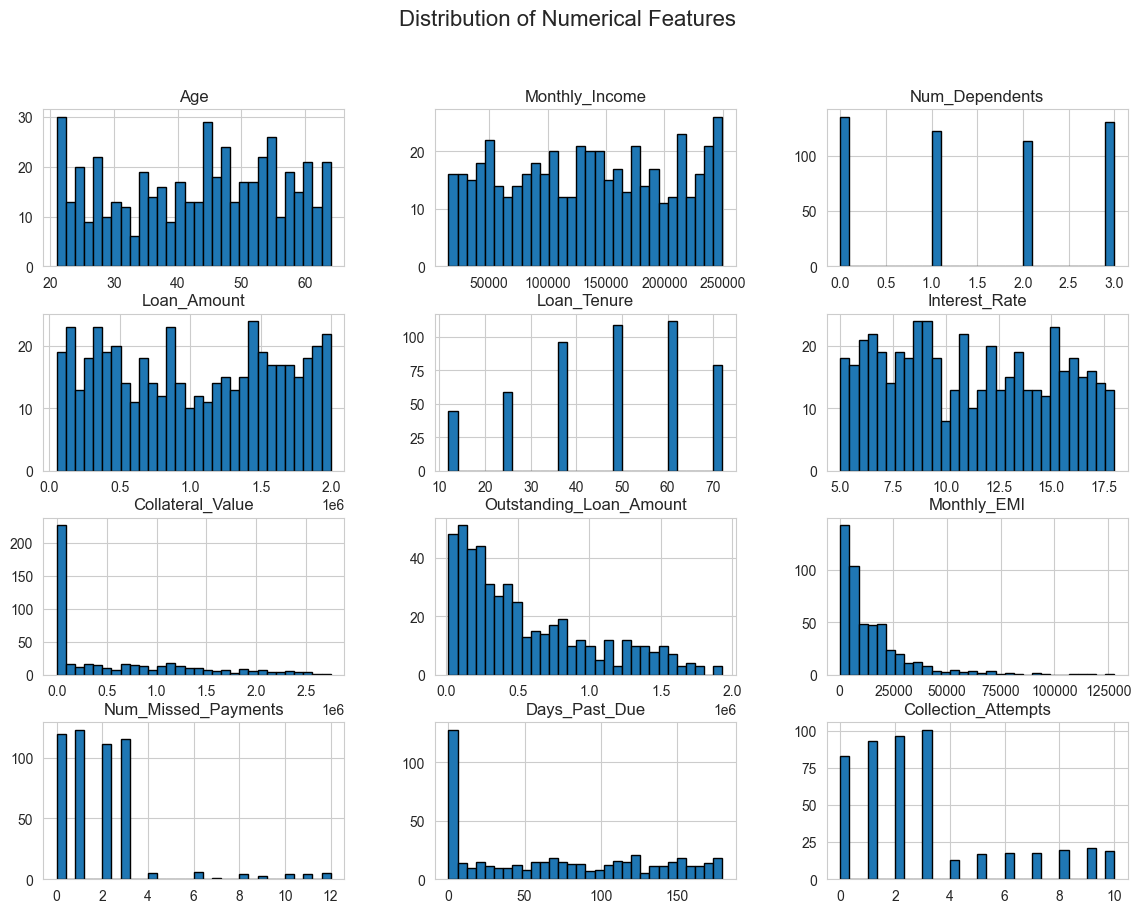

In [8]:
# Set plot style
sns.set_style("whitegrid")

# Plot histograms for numerical features
data.hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()




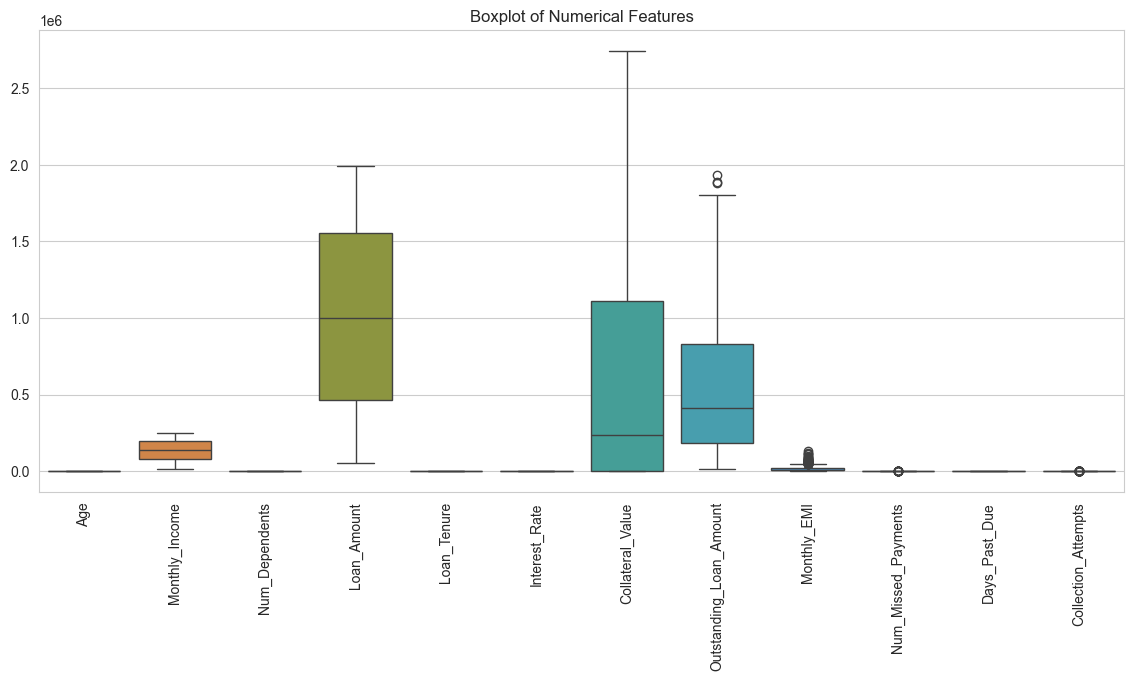

In [9]:
# Boxplots to check for outliers
plt.figure(figsize=(14, 6))
sns.boxplot(data=data.select_dtypes(include=['number']))
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features")
plt.show()

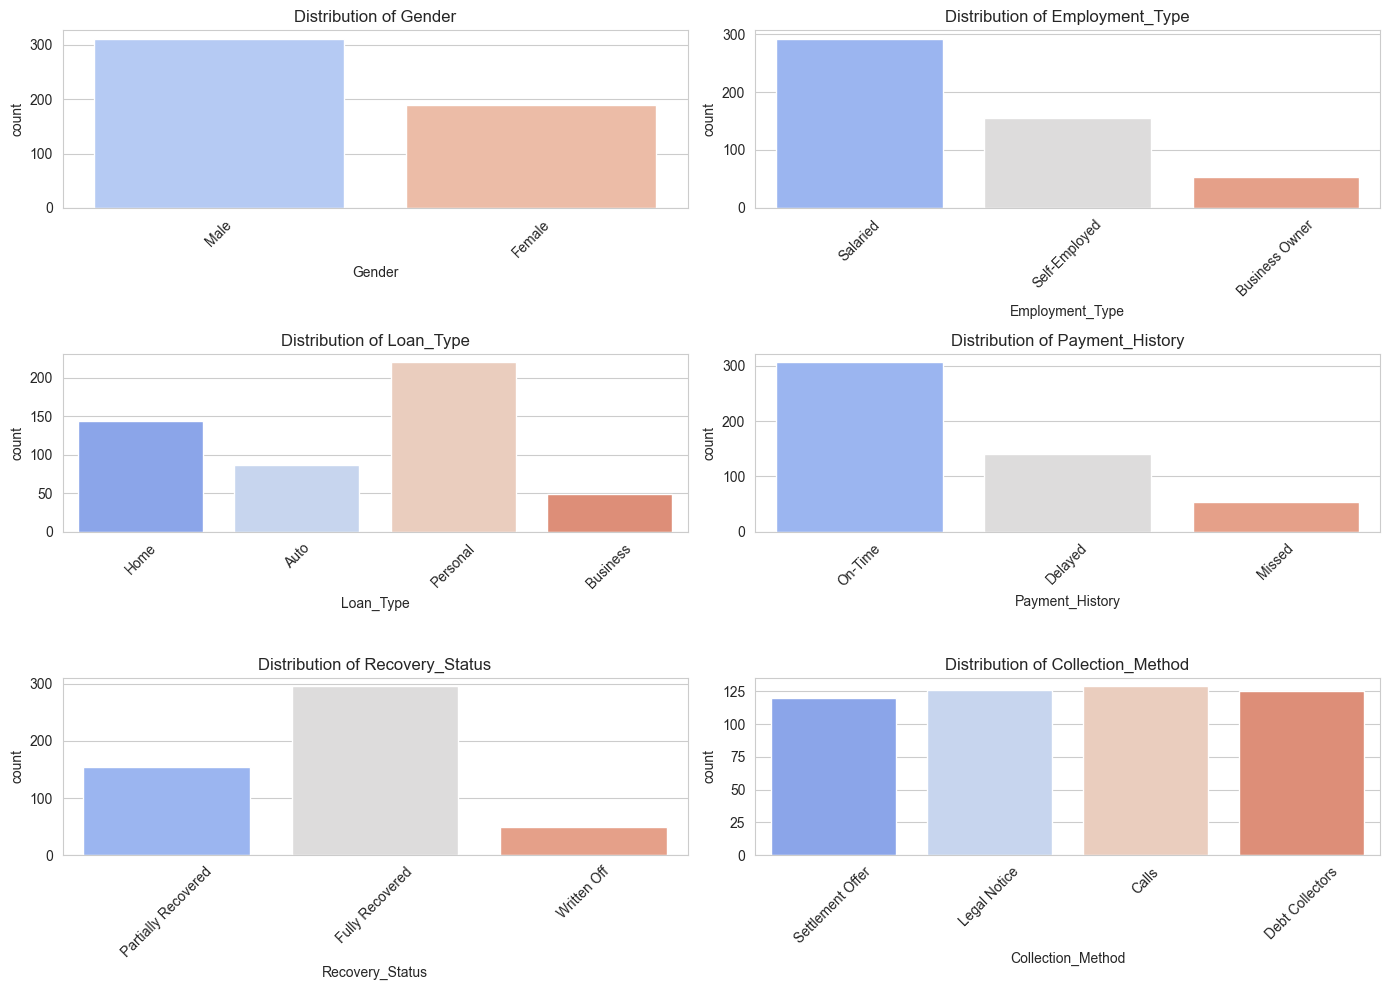

In [10]:
# Categorical features
categorical_columns = ['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Recovery_Status', 'Collection_Method']

plt.figure(figsize=(14, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(x=col, data=data, hue=col, palette="coolwarm", legend=False)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


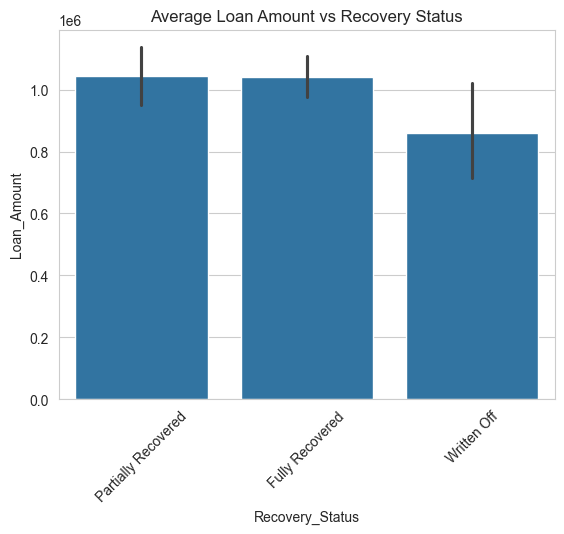

In [11]:
sns.barplot(x='Recovery_Status', y='Loan_Amount', data=data, estimator=np.mean, hue=None)
plt.title("Average Loan Amount vs Recovery Status")
plt.xticks(rotation=45)
plt.show()


Do Interest Rates impact Recovery Status?

C:\Users\Hp\AppData\Local\Temp\ipykernel_4336\3183357769.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recovery_Status', y='Interest_Rate', data=data, palette="viridis")


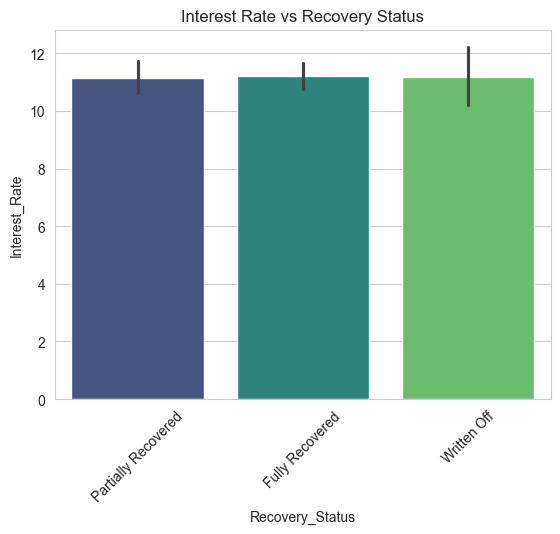

In [12]:
sns.barplot(x='Recovery_Status', y='Interest_Rate', data=data, palette="viridis")
plt.title("Interest Rate vs Recovery Status")
plt.xticks(rotation=45)
plt.show()


How does Payment History relate to Recovery Status?

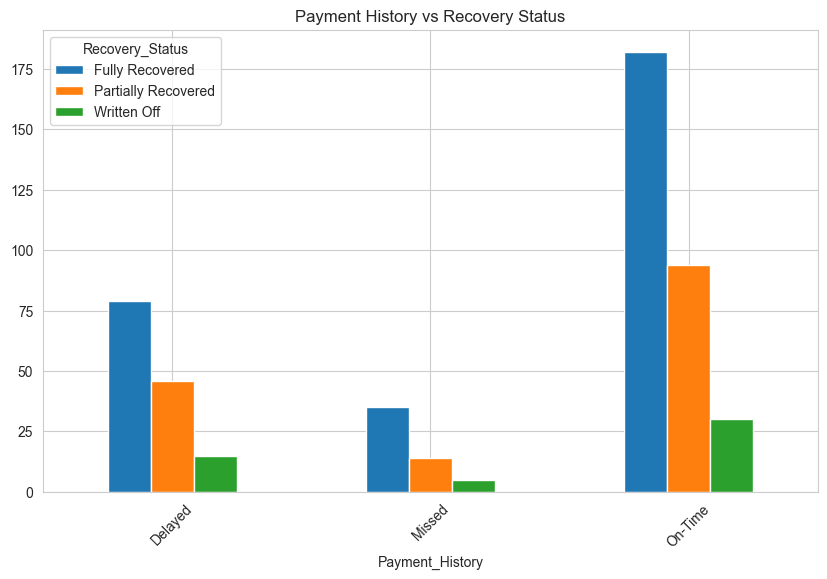

In [13]:
pd.crosstab(data['Payment_History'], data['Recovery_Status']).plot(kind="bar", figsize=(10, 6))
plt.title("Payment History vs Recovery Status")
plt.xticks(rotation=45)
plt.show()


What are the top collection methods used?

C:\Users\Hp\AppData\Local\Temp\ipykernel_4336\3555281271.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Collection_Method', data=data, palette="coolwarm", order=data['Collection_Method'].value_counts().index)


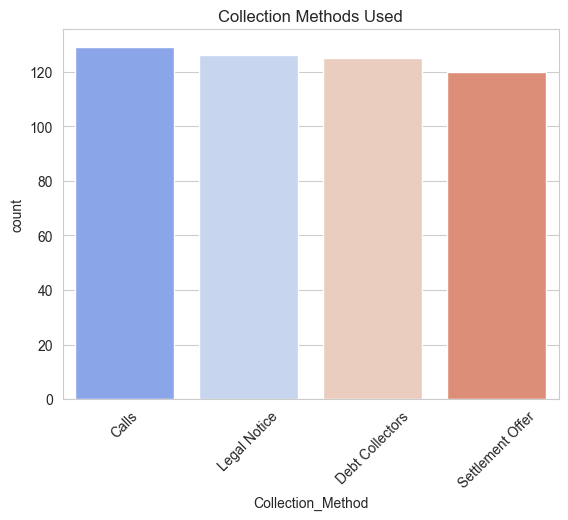

In [14]:
sns.countplot(x='Collection_Method', data=data, palette="coolwarm", order=data['Collection_Method'].value_counts().index)
plt.title("Collection Methods Used")
plt.xticks(rotation=45)
plt.show()


Does Employment Type affect Loan Recovery?

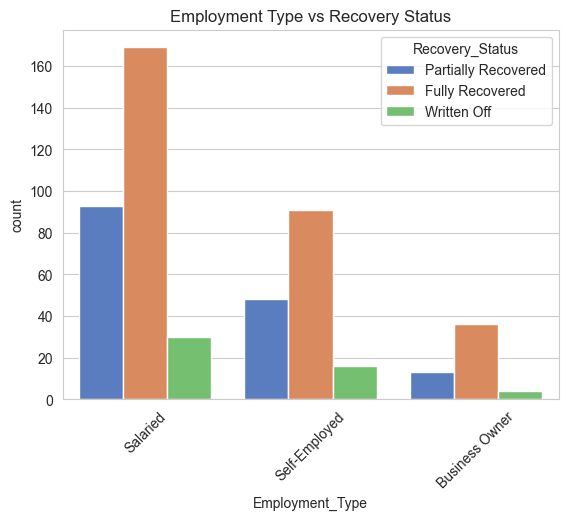

In [15]:
sns.countplot(x='Employment_Type', hue='Recovery_Status', data=data, palette="muted")
plt.title("Employment Type vs Recovery Status")
plt.xticks(rotation=45)
plt.show()


Is Age a factor in loan repayment?

C:\Users\Hp\AppData\Local\Temp\ipykernel_4336\1027985707.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Recovery_Status', y='Age', data=data, palette="coolwarm")


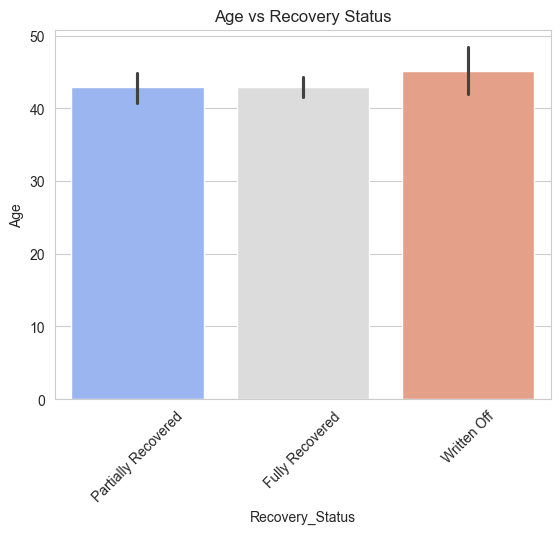

In [16]:
sns.barplot(x='Recovery_Status', y='Age', data=data, palette="coolwarm")
plt.title("Age vs Recovery Status")
plt.xticks(rotation=45)
plt.show()


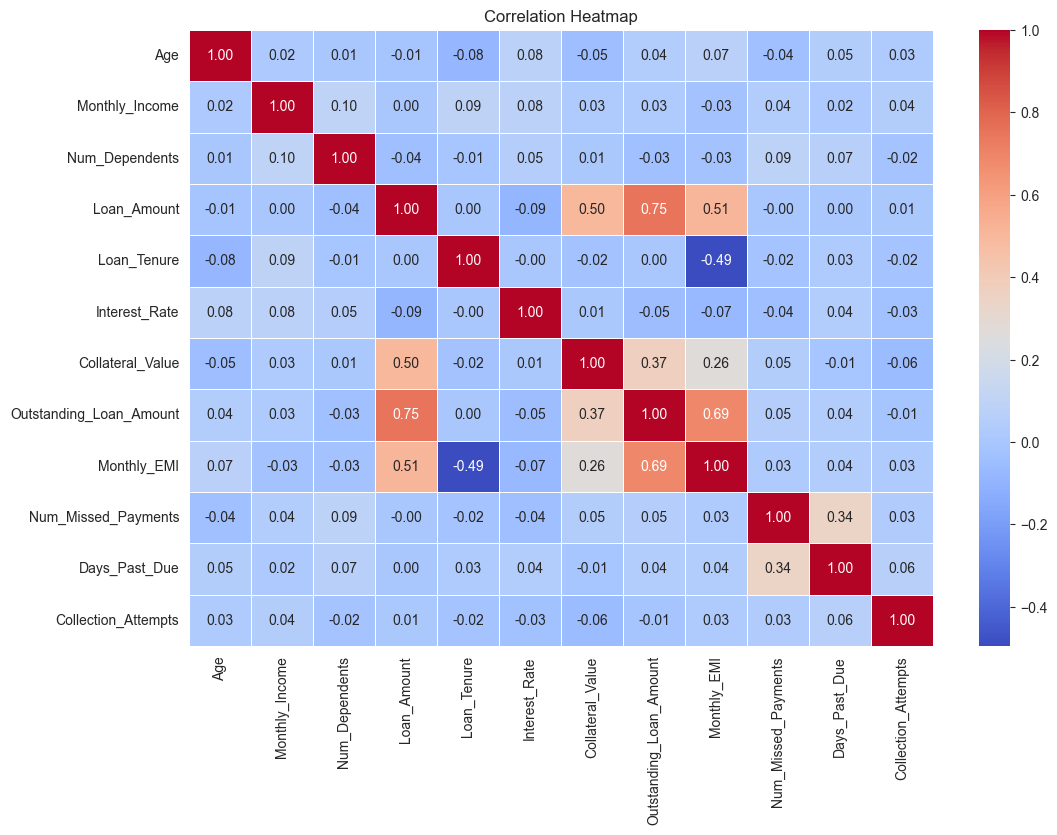

In [17]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_data.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


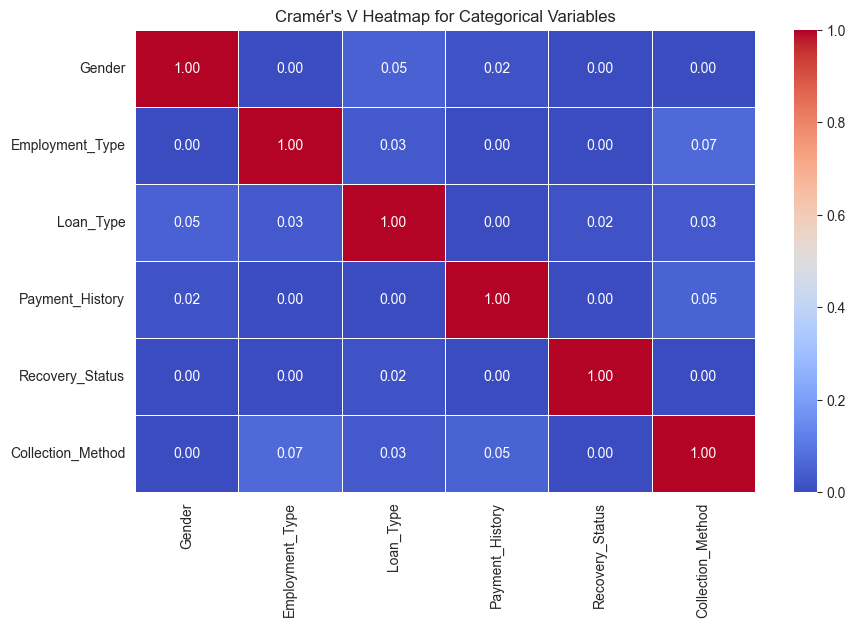

In [18]:
# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((k_corr - 1), (r_corr - 1)))

# Compute Cramér's V for all categorical pairs
categorical_columns = ['Gender', 'Employment_Type', 'Loan_Type', 'Payment_History', 'Recovery_Status', 'Collection_Method']
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0  # Perfect correlation with itself
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

# Convert to float
cramers_v_matrix = cramers_v_matrix.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cramers_v_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Cramér's V Heatmap for Categorical Variables")
plt.show()

In [19]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data['Gender'], data['Recovery_Status'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print results
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")

# Interpretation
if p < 0.05:
    print("There is a significant relationship between Gender and Recovery Status.")
else:
    print("No significant relationship between Gender and Recovery Status.")


Chi-Square Statistic: 1.7604761518404135
P-value: 0.4146841736122415
No significant relationship between Gender and Recovery Status.


<Figure size 800x500 with 0 Axes>

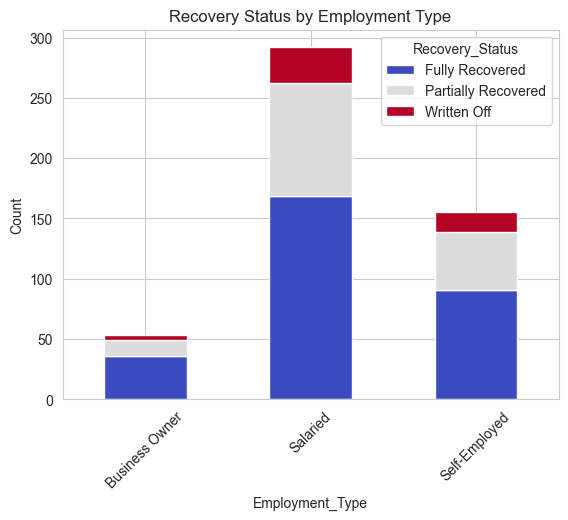

In [20]:
plt.figure(figsize=(8, 5))
pd.crosstab(data['Employment_Type'], data['Recovery_Status']).plot(kind='bar', stacked=True, colormap="coolwarm")
plt.title("Recovery Status by Employment Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for numerical features
X = data.select_dtypes(include=['number'])  # Select only numerical features
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF values
print(vif_data)


                    Feature        VIF
0                       Age   9.593478
1            Monthly_Income   4.807808
2            Num_Dependents   2.662646
3               Loan_Amount  10.088514
4               Loan_Tenure   9.758265
5             Interest_Rate   8.217826
6          Collateral_Value   2.251672
7   Outstanding_Loan_Amount   9.001082
8               Monthly_EMI   5.343800
9       Num_Missed_Payments   2.070359
10            Days_Past_Due   2.749570
11      Collection_Attempts   2.149388


In [22]:
# Define target variable
target = "Recovery_Status" 

In [23]:
# Encode target variable (Fix for the ValueError)
label_encoder = LabelEncoder()
data[target] = label_encoder.fit_transform(data[target]) 

# Identify categorical and numerical columns
categorical_cols = ["Gender", "Employment_Type", "Loan_Type", "Payment_History", "Collection_Method", "Legal_Action_Taken"]
numerical_cols = ["Monthly_Income", "Num_Dependents", "Interest_Rate", "Collateral_Value", "Num_Missed_Payments", "Days_Past_Due", "Collection_Attempts"]

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


In [24]:
X = data[numerical_cols + categorical_cols]
y = data[target]  # Now numeric labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [31]:
# Models to train
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

In [32]:
# Train and evaluate models
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    # Get predicted probabilities for log loss
    if hasattr(model, "predict_proba"):  
        y_prob = pipeline.predict_proba(X_test)
        log_loss_value = log_loss(y_test, y_prob)  #Now log_loss works
    else:
        log_loss_value = "Not Available (model does not support predict_proba)"
    
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Log Loss:", log_loss_value)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Model: Logistic Regression
Accuracy: 0.81
Log Loss: 0.6217409618902285
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.93      0.87        59
           1       0.77      0.65      0.70        31
           2       1.00      0.60      0.75        10

    accuracy                           0.81       100
   macro avg       0.86      0.73      0.77       100
weighted avg       0.82      0.81      0.80       100

Confusion Matrix:
 [[55  4  0]
 [11 20  0]
 [ 2  2  6]]

Model: Random Forest
Accuracy: 0.86
Log Loss: 0.4925254119249528
Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        59
           1       0.91      0.68      0.78        31
           2       1.00      0.60      0.75        10

    accuracy                           0.86       100
   macro avg       0.91      0.76      0.81       100
weighted avg       0.87      0.86      0.85       1

**Summary of Model Performance**


| Model                | Accuracy | Log Loss | Precision (Avg) | Recall (Avg) | F1-score (Avg) |
|----------------------|----------|------------|----------------|------------|----------------|
| **Logistic Regression** | **0.81**     | **0.6217**  | **0.82**           | **0.81**       | **0.80**          |
| **Random Forest**    | **0.86** | **0.4925**  | **0.87**       | **0.86**   | **0.85**          |
| **XGBoost**         | **0.86** | **0.5858**      | **0.86**           | **0.86**       | **0.86**       |

**Best Model:** Random Forest

The Random Forest model performed the best based on accuracy (0.86) and log loss (0.4925), which is the lowest log loss among the three models.

- Log loss measures how uncertain the model's predictions are—lower is better, and Random Forest had the lowest.

- Accuracy is also the highest at 86%, meaning it correctly predicts loan recovery status more often than Logistic Regression.

- Precision, recall, and F1-score are balanced, making it a strong choice overall.


In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter
# Transform the training data first
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train)

# Check new class distribution
print("Before SMOTE:", Counter(y_train))  
print("After SMOTE:", Counter(y_train_resampled))


Before SMOTE: Counter({0: 237, 1: 123, 2: 40})
After SMOTE: Counter({0: 237, 1: 237, 2: 237})


In [39]:
# Train models on resampled data
for name, model in models.items():
    pipeline = Pipeline([
        ('classifier', model)  # No need for preprocessor; data is already transformed
    ])
    
    pipeline.fit(X_train_resampled, y_train_resampled)  # Train on resampled data
    y_pred = pipeline.predict(preprocessor.transform(X_test))  # Transform X_test before predicting
    
    # Get predicted probabilities for log loss
    if hasattr(model, "predict_proba"):  
        y_prob = pipeline.predict_proba(preprocessor.transform(X_test))
        log_loss_value = log_loss(y_test, y_prob)
    else:
        log_loss_value = "Not Available (model does not support predict_proba)"
    
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Log Loss:", log_loss_value)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Model: Logistic Regression
Accuracy: 0.61
Log Loss: 0.7724224793790286
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.66      0.72        59
           1       0.44      0.52      0.48        31
           2       0.40      0.60      0.48        10

    accuracy                           0.61       100
   macro avg       0.55      0.59      0.56       100
weighted avg       0.65      0.61      0.62       100

Confusion Matrix:
 [[39 18  2]
 [ 8 16  7]
 [ 2  2  6]]

Model: Random Forest
Accuracy: 0.87
Log Loss: 0.5319315919433594
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91        59
           1       0.92      0.71      0.80        31
           2       1.00      0.60      0.75        10

    accuracy                           0.87       100
   macro avg       0.92      0.77      0.82       100
weighted avg       0.88      0.87      0.86       1